In [9]:
from qiskit_aer import AerSimulator
from qiskit.circuit.library import EfficientSU2
import numpy as np
from scipy.optimize import minimize
from qiskit import transpile, qasm3
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit.circuit import QuantumCircuit, ParameterVector
import matplotlib.pyplot as plt

def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

In [10]:
simulator_aer = AerSimulator()

ansatz = QuantumCircuit(4, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(4, "c1"), list(range(4)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p1"), list(range(4)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c2"), list(range(2, 4)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p2"), list(range(2, 4)), inplace=True)

In [11]:
def cost_function(params):
    # Create a new circuit with the ansatz and assign the parameters
    bound_circuit = ansatz.assign_parameters(params)   
    bound_circuit.save_statevector()
    # Get the statevector from the circuit
    qc_aer = transpile(bound_circuit, backend=simulator_aer)
    result = simulator_aer.run(qc_aer).result()
    output_state = result.get_statevector()
    
    # Calculate the probability of measuring 1 at the last qubit
    prob = -sum(np.abs(output_state[i])**2 for i in range(9, 16))
    # prob = -sum(np.abs(output_state[i])**2 for i in range(16) if i%2==1)

    
    # Return infidelity
    return prob

In [12]:
# Number of parameters in the ansatz
num_params = ansatz.num_parameters

# Initialize parameters randomly
initial_params = np.random.uniform(0, 2*np.pi, num_params)

# Perform the optimization
result = minimize(cost_function, initial_params, method='COBYLA', options={'maxiter': 1000, 'disp': True})

# Extract optimized parameters
optimized_params = result.x

print("Optimization Success:", result.success)
print("Final Infidelity:", result.fun)

Optimization Success: True
Final Infidelity: -0.9999999951460999


Final Fidelity: 0.9999999951460999


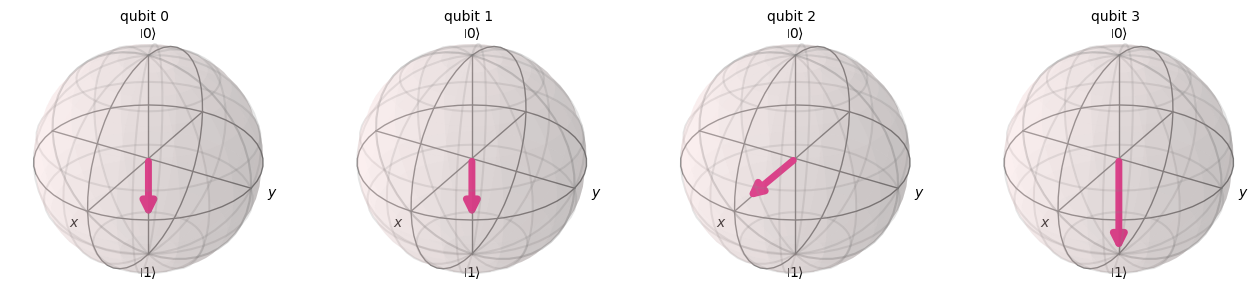

In [13]:
# Bind the optimized parameters
final_circuit = ansatz.assign_parameters(optimized_params)
# Save the qasm file of the circuit
qasm_str = qasm3.dumps(final_circuit.decompose())
final_circuit.save_statevector()
# Execute the circuit
qc_aer = transpile(final_circuit, backend=simulator_aer)
result = simulator_aer.run(qc_aer).result()
final_state = result.get_statevector()

# Calculate fidelity
prob = sum(np.abs(final_state[i])**2 for i in range(9, 16))
print("Final Fidelity:", prob)

# Optional: Visualize the final state
# This will create Bloch sphere representations for each qubit
state = Statevector(final_state)
state.draw('bloch')

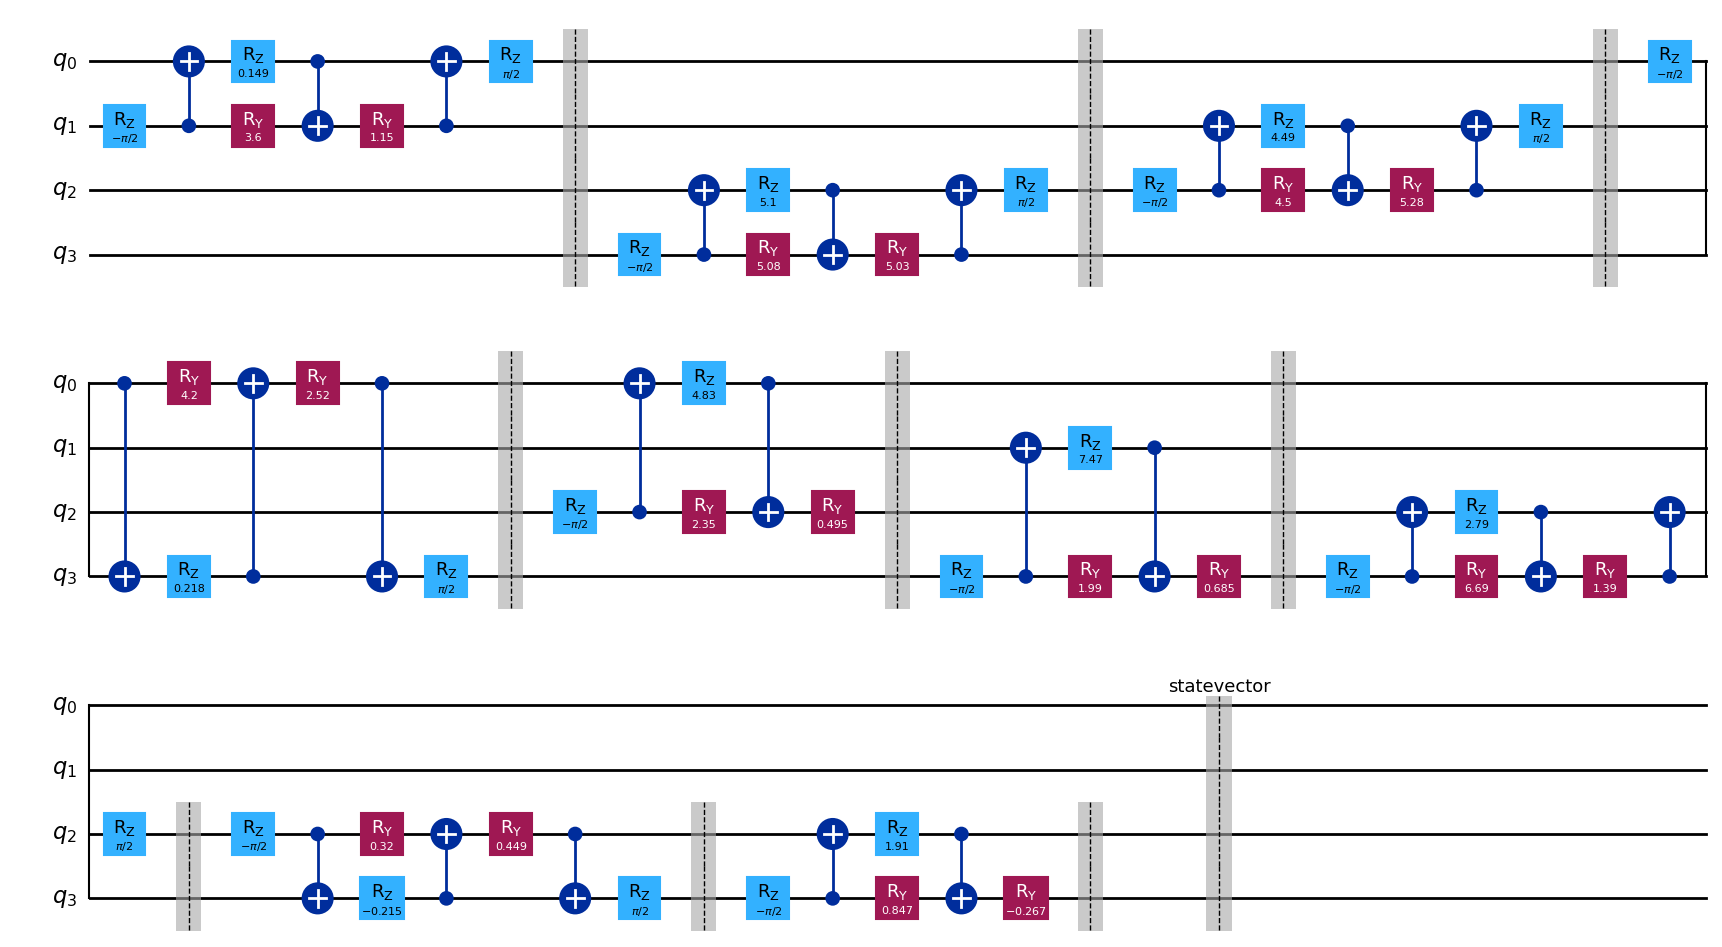

In [14]:
# Draw the final circuit
final_circuit.decompose().draw('mpl')

In [15]:
print("Final State:", np.round(final_state, 2))

Final State: [ 0.  -0.j    0.  +0.j    0.  +0.j   -0.  +0.j    0.  -0.j    0.  +0.j
  0.  +0.j    0.  -0.j    0.  -0.j    0.  +0.j    0.  +0.j   -0.11-0.37j
  0.41-0.1j   0.  +0.j    0.  +0.j   -0.71+0.4j ]


In [16]:
print(qasm_str)

OPENQASM 3.0;
include "stdgates.inc";
qubit[4] q;
rz(-pi/2) q[1];
cx q[1], q[0];
rz(0.14927700808223474) q[0];
ry(3.603091809355944) q[1];
cx q[0], q[1];
ry(1.1476480639120201) q[1];
cx q[1], q[0];
rz(pi/2) q[0];
barrier q[0], q[1], q[2], q[3];
rz(-pi/2) q[3];
cx q[3], q[2];
rz(5.098205711126032) q[2];
ry(5.078354440812798) q[3];
cx q[2], q[3];
ry(5.026533590147101) q[3];
cx q[3], q[2];
rz(pi/2) q[2];
barrier q[0], q[1], q[2], q[3];
rz(-pi/2) q[2];
cx q[2], q[1];
rz(4.494418824717604) q[1];
ry(4.495849614545601) q[2];
cx q[1], q[2];
ry(5.27887813102418) q[2];
cx q[2], q[1];
rz(pi/2) q[1];
barrier q[0], q[1], q[2], q[3];
rz(-pi/2) q[0];
cx q[0], q[3];
ry(4.196663081748407) q[0];
rz(0.21787397776290354) q[3];
cx q[3], q[0];
ry(2.5200364688356593) q[0];
cx q[0], q[3];
rz(pi/2) q[3];
barrier q[0], q[1], q[2], q[3];
rz(-pi/2) q[2];
cx q[2], q[0];
rz(4.832341669202954) q[0];
ry(2.3529414188159734) q[2];
cx q[0], q[2];
ry(0.4954547010465287) q[2];
barrier q[0], q[1], q[2], q[3];
rz(-pi/2) q[3